In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def check_label_frequencies(ns, d, subdatasets):

    # Initialize structure to track the number of occurrences for each label for each task for 
    # each subdataset
    output = [[{i: 0 for i in range(ns[j])} for j in range(d)] for _ in range(len(subdatasets))]
    
    # Check each subdataset
    for i in range(len(subdatasets)):
        subdataset = subdatasets[i]
   
        # Get the frequency of each of each task's labels for each combination present in the subdataset
        for k in range(len(subdataset)):
            comb = subdataset[k]
            for j in range(d):
                output[i][j][comb[j]] += 1

        # Check that each label frequency is approximately the total number of combinations divided by 
        # the product of the subdataset size and the amount of labels available for the given task
        for j in range(d):
            desired_val = 1.
            for n in ns:
                desired_val *= n
            desired_val /= (ns[j] * len(subdatasets))
            for k in range(ns[j]):
                assert output[i][j][k] ==  np.ceil(desired_val) or output[i][j][k] == np.floor(desired_val)


def check_label_pair_frequencies(ns, d, subdatasets):

    # Check each subdataset
    for i in range(len(subdatasets)):
        subdataset = subdatasets[i]
        
        # Initialize frequencies at 0
        spvc = {}
        for a in range(d - 1):
            for b in range(a + 1, d):
                spvc[(a, b)] = {}
                for x in range(ns[a]):
                    for y in range(ns[b]):
                        spvc[(a, b)][(x, y)] = 0
        
        # Count the frequencies of each pair of values for each pair of dimensions
        for comb in subdataset:
            for a in range(d - 1):
                for b in range(a + 1, d):
                    spvc[(a, b)][(comb[a], comb[b])] += 1

        # Assert that the frequency for each combination of two tasks' labels is approximately the 
        # total number of all combinations divided by the product of the number of subdatasets
        # and the sizes of both tasks' output spaces
        
        # Get total number of combinations
        ns_prod = 1
        for n in ns:
            ns_prod *= n
        
        # Check each pair of tasks
        for a in range(d - 1):
            for b in range(a + 1, d):
                # Check each pair of labels for those tasks
                for x in range(ns[a]):
                    for y in range(ns[b]):
                        assert spvc[(a, b)][(x, y)] == np.floor(ns_prod / (len(subdatasets) * ns[a] * ns[b])) or \
                               spvc[(a, b)][(x, y)] == np.ceil(ns_prod / (len(subdatasets) * ns[a] * ns[b]))


def check_label_triplet_frequencies(ns, d, subdatasets):

    # Check each subdataset
    for i in range(len(subdatasets)):
        subdataset = subdatasets[i]
        
        # Initialize frequencies at 0
        spvc = {}
        for a in range(d - 2):
            for b in range(a + 1, d - 1):
                for c in range(b + 1, d):
                    spvc[(a, b, c)] = {}
                    for x in range(ns[a]):
                        for y in range(ns[b]):
                            for z in range(ns[c]):
                                spvc[(a, b, c)][(x, y, z)] = 0
        
        # Count the frequencies of each pair of values for each pair of dimensions
        for comb in subdataset:
            for a in range(d - 2):
                for b in range(a + 1, d - 1):
                    for c in range(b + 1, d):
                        spvc[(a, b, c)][(comb[a], comb[b], comb[c])] += 1

        # Assert that the frequency for each combination of two tasks' labels is approximately the 
        # total number of all combinations divided by the product of the number of subdatasets
        # and the sizes of both tasks' output spaces
        
        # Get total number of combinations
        ns_prod = 1
        for n in ns:
            ns_prod *= n
        
        # Check each triplet of tasks
        for a in range(d - 2):
            for b in range(a + 1, d - 1):
                for c in range(b + 1, d):
                    # Check each triplet of labels for those tasks
                    for x in range(ns[a]):
                        for y in range(ns[b]):
                            for z in range(ns[c]):
                                assert spvc[(a, b, c)][(x, y, z)] == np.floor(ns_prod / (len(subdatasets) * ns[a] * ns[b] * ns[c])) or \
                                       spvc[(a, b, c)][(x, y, z)] == np.ceil(ns_prod / (len(subdatasets) * ns[a] * ns[b] * ns[c]))

    
def check_combs_valid(ns, d, subdatasets):
    
    # Assert that all combinations occur exactly once across subdatasets
    unique = set()
    total_num = 0
    for subdataset in subdatasets:
        for item in subdataset:
            unique.add(item)
            total_num += 1

    expected_num_unique = np.prod(ns[:d])
    assert total_num == expected_num_unique
    assert total_num == len(unique) 

    # Check that the combinations are dispersed fairly among subdatasets
    check_label_frequencies(ns[:d], d, subdatasets)
    if d > 2:
        check_label_pair_frequencies(ns[:d], d, subdatasets)
    if d > 3:
        check_label_triplet_frequencies(ns[:d], d, subdatasets)


In [3]:
# ns: sorted list containing number of classes per task
def get_combs(ns):
    d = len(ns)
    assert d >= 2, "need multiple dimensions to make combinations"
    
    # The number of subdatasets is set to be the size of the smallest task
    n_sub = ns[0]

    # 1d combs (base case)
    subdatasets = [[(i,)] for i in range(n_sub)]
    
    # Iteratively generate valid subdatasets for additional dimensions
    for j in range(2, d + 1):
        subdatasets = helper(n_sub, ns[j - 2], ns[j - 1], subdatasets, j)
        print(str(j) + "D COMBS")
        for i in range(ns[0]):
            print("  subdataset " + str(i) + ":")
            print("    ", subdatasets[i])
        check_combs_valid(ns, j, subdatasets)

    return subdatasets


# Get dimension-(d+1) subdatasets from dimension-(d) subdatasets
def helper(n_sub, prev_n, n, combs, dim):
    
    # Generate n_sub subdatasets
    subdatasets = []
    for i in range(n_sub):
        subdataset = []
        
        # Iterate over values to add in new dimension
        used = set()
        next_sub = i
        for j in range(n):
            used.add(next_sub)
            
            for comb in combs[next_sub]:
                subdataset.append(tuple(list(comb) + [(j) % n]))
                
            if dim > 2:
                if len(used) == n_sub:
                    used = set()

                next_sub = (next_sub + ((1) * prev_n)) % n_sub
                count = -1
                while next_sub in used:
                    count += 1
                    next_sub = (next_sub + 1) % n_sub
            else:
                next_sub = (next_sub + 1) % n_sub

        subdatasets.append(subdataset)

    return subdatasets
    

In [4]:
result = get_combs((9,9,9,9))

2D COMBS
  subdataset 0:
     [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8)]
  subdataset 1:
     [(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (0, 8)]
  subdataset 2:
     [(2, 0), (3, 1), (4, 2), (5, 3), (6, 4), (7, 5), (8, 6), (0, 7), (1, 8)]
  subdataset 3:
     [(3, 0), (4, 1), (5, 2), (6, 3), (7, 4), (8, 5), (0, 6), (1, 7), (2, 8)]
  subdataset 4:
     [(4, 0), (5, 1), (6, 2), (7, 3), (8, 4), (0, 5), (1, 6), (2, 7), (3, 8)]
  subdataset 5:
     [(5, 0), (6, 1), (7, 2), (8, 3), (0, 4), (1, 5), (2, 6), (3, 7), (4, 8)]
  subdataset 6:
     [(6, 0), (7, 1), (8, 2), (0, 3), (1, 4), (2, 5), (3, 6), (4, 7), (5, 8)]
  subdataset 7:
     [(7, 0), (8, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8)]
  subdataset 8:
     [(8, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)]
3D COMBS
  subdataset 0:
     [(0, 0, 0), (1, 1, 0), (2, 2, 0), (3, 3, 0), (4, 4, 0), (5, 5, 0), (6, 6, 0), (7, 7, 0), (8, 8, 0), (1, 0, 1), (2, 

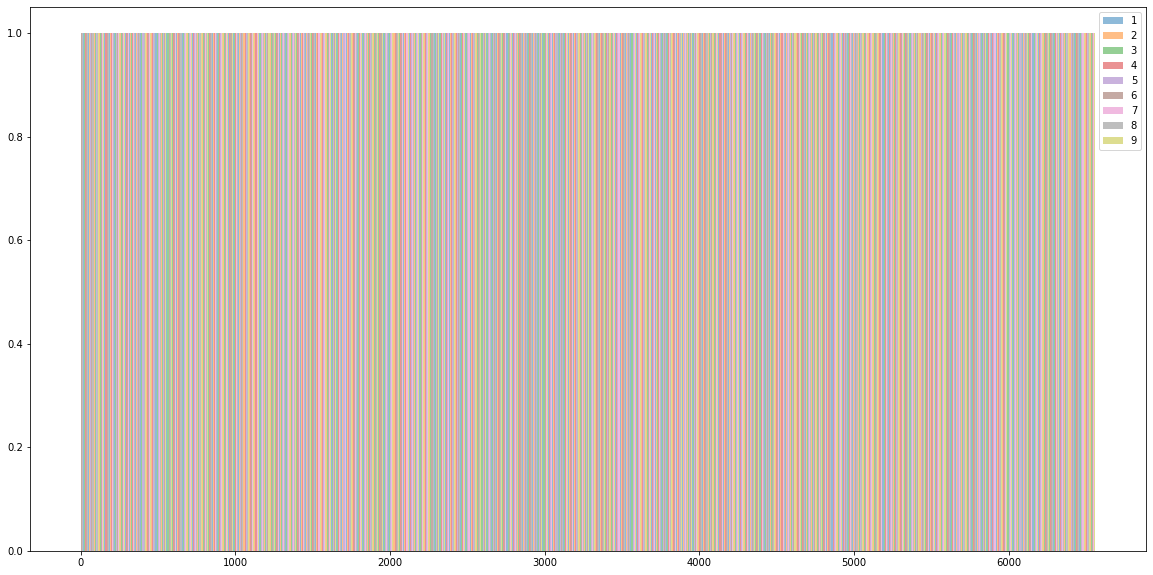

0


In [16]:
comb_to_id = {}
id_counter = 0
for a in range(9):
    for b in range(9):
        for c in range(9):
            for d in range(9):
                comb_to_id[(a,b,c,d)] = id_counter
                id_counter += 1
comb_set = set(comb_to_id.values())
                
bins = range(6561)
result2 = result.copy()
for i in range(len(result2)):
    comb_set -= set([comb_to_id[j] for j in result2[i]])
    plt.hist([comb_to_id[j] for j in result2[i]], alpha=0.5, bins=bins, label=str(i + 1))
    
plt.legend()
plt.rcParams["figure.figsize"] = (20,10)
plt.savefig("out.png", dpi=200)
plt.show()

print(len(comb_set))
# for i in range(len(result2)):

#     result3 = temp + result2[i]
#     print("\nSUBDATASET ", i)
#     count = Counter(result2[i])
#     df = pandas.DataFrame.from_dict(count, orient='index')
#     df.plot(kind='bar')
#     plt.show()
#     plt.clf()

In [21]:
from collections import Counter

comb_to_id = {}
freqs = {}
id_counter = 0
for a in range(9):
    for b in range(9):
        for c in range(9):
            for d in range(9):
                comb_to_id[(a,b,c,d)] = id_counter
                freqs[id_counter] = 0
                id_counter += 1
comb_set = set(comb_to_id.values())
                
bins = range(6561)
counter = 0
result2 = result.copy()
for i in range(3):#len(result2)):
    for j in result2[i]:
        counter += 1
        freqs[comb_to_id[j]] += 1
    comb_set -= set([comb_to_id[j] for j in result2[i]])
print(counter)
print(Counter(freqs).most_common())


2187
[(0, 1), (7, 1), (8, 1), (15, 1), (16, 1), (17, 1), (23, 1), (24, 1), (25, 1), (31, 1), (32, 1), (33, 1), (39, 1), (40, 1), (41, 1), (47, 1), (48, 1), (49, 1), (55, 1), (56, 1), (57, 1), (63, 1), (64, 1), (65, 1), (72, 1), (73, 1), (80, 1), (87, 1), (88, 1), (89, 1), (95, 1), (96, 1), (97, 1), (103, 1), (104, 1), (105, 1), (111, 1), (112, 1), (113, 1), (119, 1), (120, 1), (121, 1), (127, 1), (128, 1), (129, 1), (135, 1), (136, 1), (137, 1), (144, 1), (145, 1), (152, 1), (153, 1), (160, 1), (161, 1), (167, 1), (168, 1), (169, 1), (175, 1), (176, 1), (177, 1), (183, 1), (184, 1), (185, 1), (191, 1), (192, 1), (193, 1), (199, 1), (200, 1), (201, 1), (207, 1), (208, 1), (209, 1), (216, 1), (217, 1), (224, 1), (225, 1), (232, 1), (233, 1), (240, 1), (241, 1), (242, 1), (247, 1), (248, 1), (249, 1), (255, 1), (256, 1), (257, 1), (263, 1), (264, 1), (265, 1), (271, 1), (272, 1), (273, 1), (279, 1), (280, 1), (281, 1), (288, 1), (289, 1), (296, 1), (297, 1), (304, 1), (305, 1), (312, 1), 

<Figure size 1440x720 with 0 Axes>

In [6]:
# import pandas
# import matplotlib.pyplot as plt
# from collections import Counter
# result2 = result.copy()

# temp = []
# for a in range(10):
#     for b in range(20):
#         for c in range(5):
#             for d in range(4):
#                 temp.append((a,b,c,d))

# for i in range(len(result2)):

#     result3 = temp + result2[i]
#     print("\nSUBDATASET ", i)
#     count = Counter(result2[i])
#     df = pandas.DataFrame.from_dict(count, orient='index')
#     df.plot(kind='bar')
#     plt.show()
#     plt.clf()
